In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

losses = pd.read_csv('./losses.csv', index_col=0, parse_dates=True)

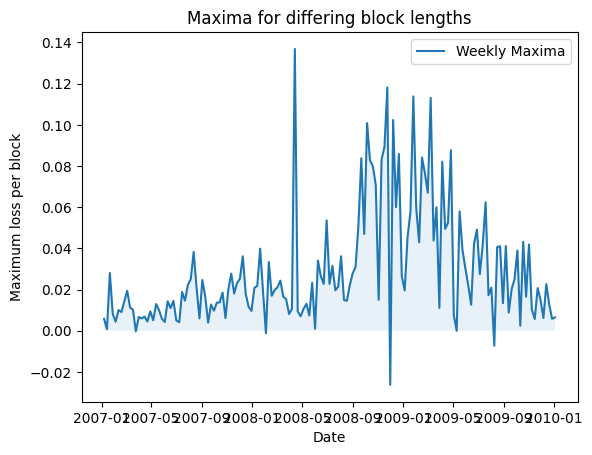

In [5]:
# Resample the data into weekly blocks
weekly_maxima = losses.resample("W").max()
axis_1 = plt.subplot(1,1,1)
# Plot the resulting weekly maxima
axis_1.plot(weekly_maxima, label = "Weekly Maxima")
axis_1.legend()
axis_1.set_title("Maxima for differing block lengths")
axis_1.set_xlabel("Date")
axis_1.set_ylabel("Maximum loss per block")
axis_1.fill_between(weekly_maxima.index, weekly_maxima.values[:, 0], 0, alpha=0.1)
plt.show()

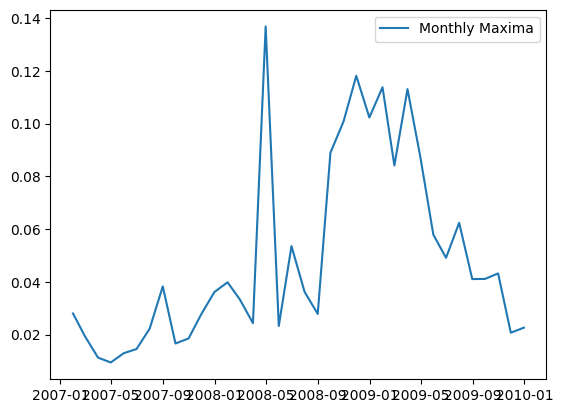

<Figure size 640x480 with 0 Axes>

In [7]:
# Resample the data into monthly blocks
monthly_maxima = losses.resample("M").max()
axis_2  = plt.subplot(1,1,1)
# Plot the resulting monthly maxima
axis_2.plot(monthly_maxima, label = "Monthly Maxima")
axis_2.legend()
plt.figure("monthly")
plt.show()

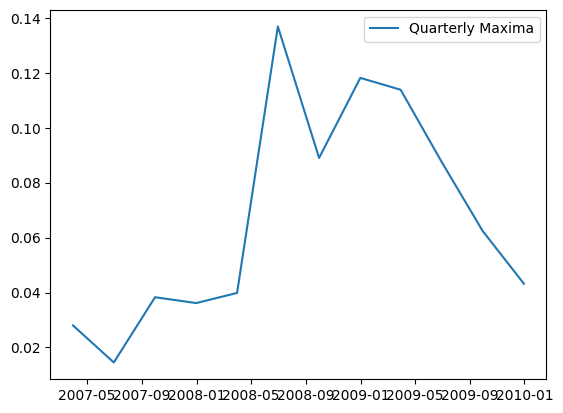

<Figure size 640x480 with 0 Axes>

In [9]:
# Resample the data into quarterly blocks
quarterly_maxima = losses.resample("Q").max()
axis_3 = plt.subplot(1,1,1)
# Plot the resulting quarterly maxima
axis_3.plot(quarterly_maxima, label = "Quarterly Maxima")
axis_3.legend()
plt.figure("quarterly")
plt.show()

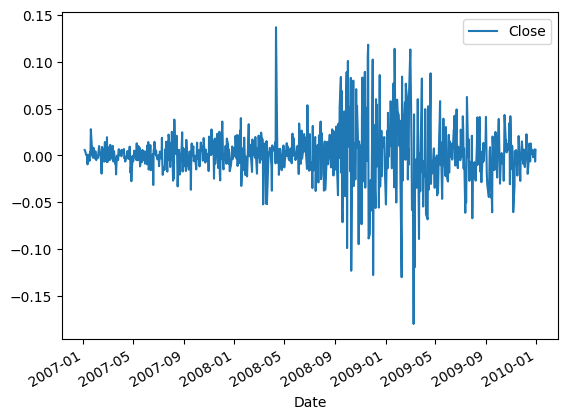

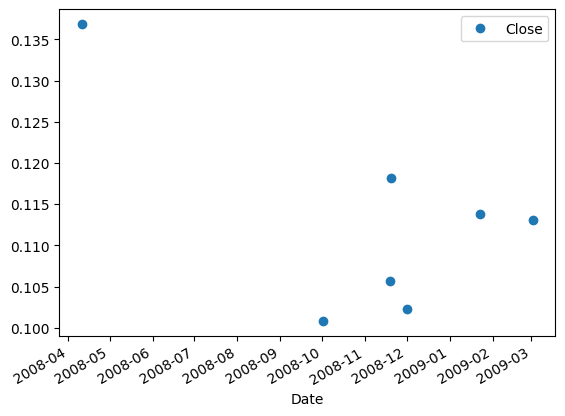

In [10]:
# Plot the log daily losses of GE over the period 2007-2009
losses.plot()

# Find all daily losses greater than 10%
extreme_losses = losses[losses > 0.10]

# Scatter plot the extreme losses
extreme_losses.plot(style='o')
plt.show()

In [19]:
weekly_max = weekly_maxima.Close

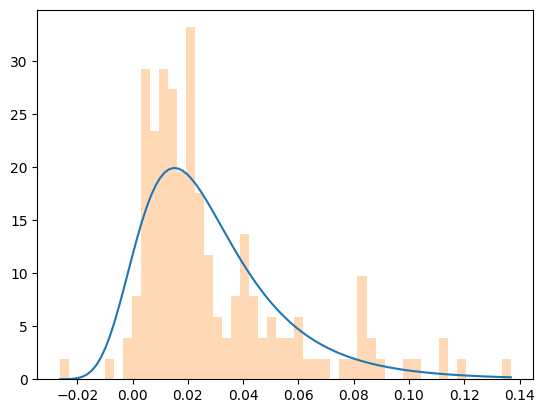

In [20]:
from scipy.stats import genextreme
# Fit extreme distribution to weekly maximum of losses
fitted = genextreme.fit(weekly_max)

# Plot extreme distribution with weekly max losses historgram
x = np.linspace(min(weekly_max), max(weekly_max), 100)
plt.plot(x, genextreme.pdf(x, *fitted))
plt.hist(weekly_max, 50, density = True, alpha = 0.3)
plt.show()

In [21]:
# Compute the weekly block maxima for GE's stock 
weekly_maxima = losses.resample("W").max()

# Fit the GEV distribution to the maxima
p = genextreme.fit(weekly_maxima)

# Compute the 99% VaR (needed for the CVaR computation) 
VaR_99 = genextreme.ppf(0.99, *p)

# Compute the 99% CVaR estimate 
CVaR_99 = (1 / (1 - 0.99)) * genextreme.expect(lambda x: x, args=(p[0],), loc=p[1], scale=p[2], lb=VaR_99)

# Display the covering loss amount 
print("Reserve amount: ", 1000000 * CVaR_99)

Reserve amount:  148202.413077065


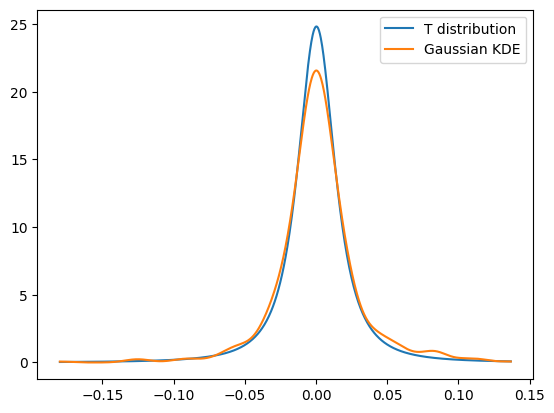

In [26]:
from scipy.stats import t 
# Generate a fitted T distribution over losses
params = t.fit(losses)
from scipy.stats import gaussian_kde
# Generate a Gaussian kernal density estimate over losses
kde = gaussian_kde(losses.T) # Transpose the input dataset
# kde = gaussian_kde(losses)
axis = plt.subplot(1,1,1)
# Add the PDFs of both estimates to a histogram, and display
loss_range = np.linspace(np.min(losses), np.max(losses), 1000)
axis.plot(loss_range, t.pdf(loss_range, *params), label='T distribution')
axis.plot(loss_range, kde.pdf(loss_range), label='Gaussian KDE')
plt.legend()
plt.show()

Right! The T and Gaussian KDE estimates are both good fits, each in a different way: the T captures the peak well, while the KDE captures the tails better.

In [29]:
# Find the VaR as a quantile of random samples from the distributions
p = (10, 0, 0.1)
if any(scale < 0 for scale in p[1:]):
    raise ValueError("All scale parameters must be positive")
VaR_99_T = np.quantile(t.rvs(size=1000, *p), 0.99)

VaR_99_T   = np.quantile(t.rvs(size=1000, *p), 0.99)
VaR_99_KDE = np.quantile(kde.resample(size=1000), 0.99)

# # Find the expected tail losses, with lower bounds given by the VaR measures
# integral_T   = t.expect(lambda x: x, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99_T)
# integral_KDE = kde.expect(lambda x: x, lb = VaR_99_KDE)

# # Create the 99% CVaR estimates
# CVaR_99_T   = (1 / (1 - 0.99)) * integral_T
# CVaR_99_KDE = (1 / (1 - 0.99)) * integral_KDE

from scipy import integrate

# Find the expected tail losses, with lower bounds given by the VaR measures
integral_T   = integrate.quad(lambda x: x * t.pdf(x, *p), VaR_99_T, np.inf)[0]
integral_KDE = integrate.quad(lambda x: x * kde.pdf(x), VaR_99_KDE, np.inf)[0]

# Create the 99% CVaR estimates
CVaR_99_T   = (1 / (1 - 0.99)) * integral_T
CVaR_99_KDE = (1 / (1 - 0.99)) * integral_KDE

# Display the results
print("99% CVaR for T: ", CVaR_99_T, "; 99% CVaR for KDE: ", CVaR_99_KDE)

99% CVaR for T:  0.41067869100132387 ; 99% CVaR for KDE:  0.1442613195225141


In [36]:

x = np.array([ 0.        ,  0.01001001,  0.02002002,  0.03003003,  0.04004004,
        0.05005005,  0.06006006,  0.07007007,  0.08008008,  0.09009009,
        0.1001001 ,  0.11011011,  0.12012012,  0.13013013,  0.14014014,
        0.15015015,  0.16016016,  0.17017017,  0.18018018,  0.19019019,
        0.2002002 ,  0.21021021,  0.22022022,  0.23023023,  0.24024024,
        0.25025025,  0.26026026,  0.27027027,  0.28028028,  0.29029029,
        0.3003003 ,  0.31031031,  0.32032032,  0.33033033,  0.34034034,
        0.35035035,  0.36036036,  0.37037037,  0.38038038,  0.39039039,
        0.4004004 ,  0.41041041,  0.42042042,  0.43043043,  0.44044044,
        0.45045045,  0.46046046,  0.47047047,  0.48048048,  0.49049049,
        0.5005005 ,  0.51051051,  0.52052052,  0.53053053,  0.54054054,
        0.55055055,  0.56056056,  0.57057057,  0.58058058,  0.59059059,
        0.6006006 ,  0.61061061,  0.62062062,  0.63063063,  0.64064064,
        0.65065065,  0.66066066,  0.67067067,  0.68068068,  0.69069069,
        0.7007007 ,  0.71071071,  0.72072072,  0.73073073,  0.74074074,
        0.75075075,  0.76076076,  0.77077077,  0.78078078,  0.79079079,
        0.8008008 ,  0.81081081,  0.82082082,  0.83083083,  0.84084084,
        0.85085085,  0.86086086,  0.87087087,  0.88088088,  0.89089089,
        0.9009009 ,  0.91091091,  0.92092092,  0.93093093,  0.94094094,
        0.95095095,  0.96096096,  0.97097097,  0.98098098,  0.99099099,
        1.001001  ,  1.01101101,  1.02102102,  1.03103103,  1.04104104,
        1.05105105,  1.06106106,  1.07107107,  1.08108108,  1.09109109,
        1.1011011 ,  1.11111111,  1.12112112,  1.13113113,  1.14114114,
        1.15115115,  1.16116116,  1.17117117,  1.18118118,  1.19119119,
        1.2012012 ,  1.21121121,  1.22122122,  1.23123123,  1.24124124,
        1.25125125,  1.26126126,  1.27127127,  1.28128128,  1.29129129,
        1.3013013 ,  1.31131131,  1.32132132,  1.33133133,  1.34134134,
        1.35135135,  1.36136136,  1.37137137,  1.38138138,  1.39139139,
        1.4014014 ,  1.41141141,  1.42142142,  1.43143143,  1.44144144,
        1.45145145,  1.46146146,  1.47147147,  1.48148148,  1.49149149,
        1.5015015 ,  1.51151151,  1.52152152,  1.53153153,  1.54154154,
        1.55155155,  1.56156156,  1.57157157,  1.58158158,  1.59159159,
        1.6016016 ,  1.61161161,  1.62162162,  1.63163163,  1.64164164,
        1.65165165,  1.66166166,  1.67167167,  1.68168168,  1.69169169,
        1.7017017 ,  1.71171171,  1.72172172,  1.73173173,  1.74174174,
        1.75175175,  1.76176176,  1.77177177,  1.78178178,  1.79179179,
        1.8018018 ,  1.81181181,  1.82182182,  1.83183183,  1.84184184,
        1.85185185,  1.86186186,  1.87187187,  1.88188188,  1.89189189,
        1.9019019 ,  1.91191191,  1.92192192,  1.93193193,  1.94194194,
        1.95195195,  1.96196196,  1.97197197,  1.98198198,  1.99199199,
        2.002002  ,  2.01201201,  2.02202202,  2.03203203,  2.04204204,
        2.05205205,  2.06206206,  2.07207207,  2.08208208,  2.09209209,
        2.1021021 ,  2.11211211,  2.12212212,  2.13213213,  2.14214214,
        2.15215215,  2.16216216,  2.17217217,  2.18218218,  2.19219219,
        2.2022022 ,  2.21221221,  2.22222222,  2.23223223,  2.24224224,
        2.25225225,  2.26226226,  2.27227227,  2.28228228,  2.29229229,
        2.3023023 ,  2.31231231,  2.32232232,  2.33233233,  2.34234234,
        2.35235235,  2.36236236,  2.37237237,  2.38238238,  2.39239239,
        2.4024024 ,  2.41241241,  2.42242242,  2.43243243,  2.44244244,
        2.45245245,  2.46246246,  2.47247247,  2.48248248,  2.49249249,
        2.5025025 ,  2.51251251,  2.52252252,  2.53253253,  2.54254254,
        2.55255255,  2.56256256,  2.57257257,  2.58258258,  2.59259259,
        2.6026026 ,  2.61261261,  2.62262262,  2.63263263,  2.64264264,
        2.65265265,  2.66266266,  2.67267267,  2.68268268,  2.69269269,
        2.7027027 ,  2.71271271,  2.72272272,  2.73273273,  2.74274274,
        2.75275275,  2.76276276,  2.77277277,  2.78278278,  2.79279279,
        2.8028028 ,  2.81281281,  2.82282282,  2.83283283,  2.84284284,
        2.85285285,  2.86286286,  2.87287287,  2.88288288,  2.89289289,
        2.9029029 ,  2.91291291,  2.92292292,  2.93293293,  2.94294294,
        2.95295295,  2.96296296,  2.97297297,  2.98298298,  2.99299299,
        3.003003  ,  3.01301301,  3.02302302,  3.03303303,  3.04304304,
        3.05305305,  3.06306306,  3.07307307,  3.08308308,  3.09309309,
        3.1031031 ,  3.11311311,  3.12312312,  3.13313313,  3.14314314,
        3.15315315,  3.16316316,  3.17317317,  3.18318318,  3.19319319,
        3.2032032 ,  3.21321321,  3.22322322,  3.23323323,  3.24324324,
        3.25325325,  3.26326326,  3.27327327,  3.28328328,  3.29329329,
        3.3033033 ,  3.31331331,  3.32332332,  3.33333333,  3.34334334,
        3.35335335,  3.36336336,  3.37337337,  3.38338338,  3.39339339,
        3.4034034 ,  3.41341341,  3.42342342,  3.43343343,  3.44344344,
        3.45345345,  3.46346346,  3.47347347,  3.48348348,  3.49349349,
        3.5035035 ,  3.51351351,  3.52352352,  3.53353353,  3.54354354,
        3.55355355,  3.56356356,  3.57357357,  3.58358358,  3.59359359,
        3.6036036 ,  3.61361361,  3.62362362,  3.63363363,  3.64364364,
        3.65365365,  3.66366366,  3.67367367,  3.68368368,  3.69369369,
        3.7037037 ,  3.71371371,  3.72372372,  3.73373373,  3.74374374,
        3.75375375,  3.76376376,  3.77377377,  3.78378378,  3.79379379,
        3.8038038 ,  3.81381381,  3.82382382,  3.83383383,  3.84384384,
        3.85385385,  3.86386386,  3.87387387,  3.88388388,  3.89389389,
        3.9039039 ,  3.91391391,  3.92392392,  3.93393393,  3.94394394,
        3.95395395,  3.96396396,  3.97397397,  3.98398398,  3.99399399,
        4.004004  ,  4.01401401,  4.02402402,  4.03403403,  4.04404404,
        4.05405405,  4.06406406,  4.07407407,  4.08408408,  4.09409409,
        4.1041041 ,  4.11411411,  4.12412412,  4.13413413,  4.14414414,
        4.15415415,  4.16416416,  4.17417417,  4.18418418,  4.19419419,
        4.2042042 ,  4.21421421,  4.22422422,  4.23423423,  4.24424424,
        4.25425425,  4.26426426,  4.27427427,  4.28428428,  4.29429429,
        4.3043043 ,  4.31431431,  4.32432432,  4.33433433,  4.34434434,
        4.35435435,  4.36436436,  4.37437437,  4.38438438,  4.39439439,
        4.4044044 ,  4.41441441,  4.42442442,  4.43443443,  4.44444444,
        4.45445445,  4.46446446,  4.47447447,  4.48448448,  4.49449449,
        4.5045045 ,  4.51451451,  4.52452452,  4.53453453,  4.54454454,
        4.55455455,  4.56456456,  4.57457457,  4.58458458,  4.59459459,
        4.6046046 ,  4.61461461,  4.62462462,  4.63463463,  4.64464464,
        4.65465465,  4.66466466,  4.67467467,  4.68468468,  4.69469469,
        4.7047047 ,  4.71471471,  4.72472472,  4.73473473,  4.74474474,
        4.75475475,  4.76476476,  4.77477477,  4.78478478,  4.79479479,
        4.8048048 ,  4.81481481,  4.82482482,  4.83483483,  4.84484484,
        4.85485485,  4.86486486,  4.87487487,  4.88488488,  4.89489489,
        4.9049049 ,  4.91491491,  4.92492492,  4.93493493,  4.94494494,
        4.95495495,  4.96496496,  4.97497497,  4.98498498,  4.99499499,
        5.00500501,  5.01501502,  5.02502503,  5.03503504,  5.04504505,
        5.05505506,  5.06506507,  5.07507508,  5.08508509,  5.0950951 ,
        5.10510511,  5.11511512,  5.12512513,  5.13513514,  5.14514515,
        5.15515516,  5.16516517,  5.17517518,  5.18518519,  5.1951952 ,
        5.20520521,  5.21521522,  5.22522523,  5.23523524,  5.24524525,
        5.25525526,  5.26526527,  5.27527528,  5.28528529,  5.2952953 ,
        5.30530531,  5.31531532,  5.32532533,  5.33533534,  5.34534535,
        5.35535536,  5.36536537,  5.37537538,  5.38538539,  5.3953954 ,
        5.40540541,  5.41541542,  5.42542543,  5.43543544,  5.44544545,
        5.45545546,  5.46546547,  5.47547548,  5.48548549,  5.4954955 ,
        5.50550551,  5.51551552,  5.52552553,  5.53553554,  5.54554555,
        5.55555556,  5.56556557,  5.57557558,  5.58558559,  5.5955956 ,
        5.60560561,  5.61561562,  5.62562563,  5.63563564,  5.64564565,
        5.65565566,  5.66566567,  5.67567568,  5.68568569,  5.6956957 ,
        5.70570571,  5.71571572,  5.72572573,  5.73573574,  5.74574575,
        5.75575576,  5.76576577,  5.77577578,  5.78578579,  5.7957958 ,
        5.80580581,  5.81581582,  5.82582583,  5.83583584,  5.84584585,
        5.85585586,  5.86586587,  5.87587588,  5.88588589,  5.8958959 ,
        5.90590591,  5.91591592,  5.92592593,  5.93593594,  5.94594595,
        5.95595596,  5.96596597,  5.97597598,  5.98598599,  5.995996  ,
        6.00600601,  6.01601602,  6.02602603,  6.03603604,  6.04604605,
        6.05605606,  6.06606607,  6.07607608,  6.08608609,  6.0960961 ,
        6.10610611,  6.11611612,  6.12612613,  6.13613614,  6.14614615,
        6.15615616,  6.16616617,  6.17617618,  6.18618619,  6.1961962 ,
        6.20620621,  6.21621622,  6.22622623,  6.23623624,  6.24624625,
        6.25625626,  6.26626627,  6.27627628,  6.28628629,  6.2962963 ,
        6.30630631,  6.31631632,  6.32632633,  6.33633634,  6.34634635,
        6.35635636,  6.36636637,  6.37637638,  6.38638639,  6.3963964 ,
        6.40640641,  6.41641642,  6.42642643,  6.43643644,  6.44644645,
        6.45645646,  6.46646647,  6.47647648,  6.48648649,  6.4964965 ,
        6.50650651,  6.51651652,  6.52652653,  6.53653654,  6.54654655,
        6.55655656,  6.56656657,  6.57657658,  6.58658659,  6.5965966 ,
        6.60660661,  6.61661662,  6.62662663,  6.63663664,  6.64664665,
        6.65665666,  6.66666667,  6.67667668,  6.68668669,  6.6966967 ,
        6.70670671,  6.71671672,  6.72672673,  6.73673674,  6.74674675,
        6.75675676,  6.76676677,  6.77677678,  6.78678679,  6.7967968 ,
        6.80680681,  6.81681682,  6.82682683,  6.83683684,  6.84684685,
        6.85685686,  6.86686687,  6.87687688,  6.88688689,  6.8968969 ,
        6.90690691,  6.91691692,  6.92692693,  6.93693694,  6.94694695,
        6.95695696,  6.96696697,  6.97697698,  6.98698699,  6.996997  ,
        7.00700701,  7.01701702,  7.02702703,  7.03703704,  7.04704705,
        7.05705706,  7.06706707,  7.07707708,  7.08708709,  7.0970971 ,
        7.10710711,  7.11711712,  7.12712713,  7.13713714,  7.14714715,
        7.15715716,  7.16716717,  7.17717718,  7.18718719,  7.1971972 ,
        7.20720721,  7.21721722,  7.22722723,  7.23723724,  7.24724725,
        7.25725726,  7.26726727,  7.27727728,  7.28728729,  7.2972973 ,
        7.30730731,  7.31731732,  7.32732733,  7.33733734,  7.34734735,
        7.35735736,  7.36736737,  7.37737738,  7.38738739,  7.3973974 ,
        7.40740741,  7.41741742,  7.42742743,  7.43743744,  7.44744745,
        7.45745746,  7.46746747,  7.47747748,  7.48748749,  7.4974975 ,
        7.50750751,  7.51751752,  7.52752753,  7.53753754,  7.54754755,
        7.55755756,  7.56756757,  7.57757758,  7.58758759,  7.5975976 ,
        7.60760761,  7.61761762,  7.62762763,  7.63763764,  7.64764765,
        7.65765766,  7.66766767,  7.67767768,  7.68768769,  7.6976977 ,
        7.70770771,  7.71771772,  7.72772773,  7.73773774,  7.74774775,
        7.75775776,  7.76776777,  7.77777778,  7.78778779,  7.7977978 ,
        7.80780781,  7.81781782,  7.82782783,  7.83783784,  7.84784785,
        7.85785786,  7.86786787,  7.87787788,  7.88788789,  7.8978979 ,
        7.90790791,  7.91791792,  7.92792793,  7.93793794,  7.94794795,
        7.95795796,  7.96796797,  7.97797798,  7.98798799,  7.997998  ,
        8.00800801,  8.01801802,  8.02802803,  8.03803804,  8.04804805,
        8.05805806,  8.06806807,  8.07807808,  8.08808809,  8.0980981 ,
        8.10810811,  8.11811812,  8.12812813,  8.13813814,  8.14814815,
        8.15815816,  8.16816817,  8.17817818,  8.18818819,  8.1981982 ,
        8.20820821,  8.21821822,  8.22822823,  8.23823824,  8.24824825,
        8.25825826,  8.26826827,  8.27827828,  8.28828829,  8.2982983 ,
        8.30830831,  8.31831832,  8.32832833,  8.33833834,  8.34834835,
        8.35835836,  8.36836837,  8.37837838,  8.38838839,  8.3983984 ,
        8.40840841,  8.41841842,  8.42842843,  8.43843844,  8.44844845,
        8.45845846,  8.46846847,  8.47847848,  8.48848849,  8.4984985 ,
        8.50850851,  8.51851852,  8.52852853,  8.53853854,  8.54854855,
        8.55855856,  8.56856857,  8.57857858,  8.58858859,  8.5985986 ,
        8.60860861,  8.61861862,  8.62862863,  8.63863864,  8.64864865,
        8.65865866,  8.66866867,  8.67867868,  8.68868869,  8.6986987 ,
        8.70870871,  8.71871872,  8.72872873,  8.73873874,  8.74874875,
        8.75875876,  8.76876877,  8.77877878,  8.78878879,  8.7987988 ,
        8.80880881,  8.81881882,  8.82882883,  8.83883884,  8.84884885,
        8.85885886,  8.86886887,  8.87887888,  8.88888889,  8.8988989 ,
        8.90890891,  8.91891892,  8.92892893,  8.93893894,  8.94894895,
        8.95895896,  8.96896897,  8.97897898,  8.98898899,  8.998999  ,
        9.00900901,  9.01901902,  9.02902903,  9.03903904,  9.04904905,
        9.05905906,  9.06906907,  9.07907908,  9.08908909,  9.0990991 ,
        9.10910911,  9.11911912,  9.12912913,  9.13913914,  9.14914915,
        9.15915916,  9.16916917,  9.17917918,  9.18918919,  9.1991992 ,
        9.20920921,  9.21921922,  9.22922923,  9.23923924,  9.24924925,
        9.25925926,  9.26926927,  9.27927928,  9.28928929,  9.2992993 ,
        9.30930931,  9.31931932,  9.32932933,  9.33933934,  9.34934935,
        9.35935936,  9.36936937,  9.37937938,  9.38938939,  9.3993994 ,
        9.40940941,  9.41941942,  9.42942943,  9.43943944,  9.44944945,
        9.45945946,  9.46946947,  9.47947948,  9.48948949,  9.4994995 ,
        9.50950951,  9.51951952,  9.52952953,  9.53953954,  9.54954955,
        9.55955956,  9.56956957,  9.57957958,  9.58958959,  9.5995996 ,
        9.60960961,  9.61961962,  9.62962963,  9.63963964,  9.64964965,
        9.65965966,  9.66966967,  9.67967968,  9.68968969,  9.6996997 ,
        9.70970971,  9.71971972,  9.72972973,  9.73973974,  9.74974975,
        9.75975976,  9.76976977,  9.77977978,  9.78978979,  9.7997998 ,
        9.80980981,  9.81981982,  9.82982983,  9.83983984,  9.84984985,
        9.85985986,  9.86986987,  9.87987988,  9.88988989,  9.8998999 ,
        9.90990991,  9.91991992,  9.92992993,  9.93993994,  9.94994995,
        9.95995996,  9.96996997,  9.97997998,  9.98998999, 10.        ])



Epoch 1/100
32/32 [==============================] - 0s 793us/step - loss: 2.9941
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 1.2500
Epoch 3/100
32/32 [==============================] - 0s 589us/step - loss: 0.4028
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1280
Epoch 5/100
32/32 [==============================] - 0s 893us/step - loss: 0.0960
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0777
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 9/100
32/32 [==============================] - 0s 551us/step - loss: 0.0360
Epoch 10/100
32/32 [==============================] - 0s 635us/step - loss: 0.0266
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0197
Epoch 12/100
32/32 [==============================] - 0s 516us/step - loss: 0.0144
Epoch 13/100
32/32 [=====

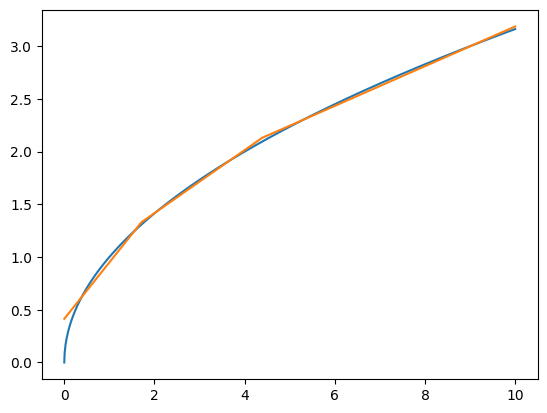

In [37]:
# Create the training values from the square root function
y = np.sqrt(x)
from keras.models import Sequential
from keras.layers import Dense
# Create the neural network
model = Sequential()
model.add(Dense(16, input_dim=1, activation='relu'))
model.add(Dense(1))

# Train the network
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(x, y, epochs=100)

## Plot the resulting approximation and the training values
plt.plot(x, y, x, model.predict(x))
plt.show()


In [40]:
prices = pd.read_csv('./crisis_portfolio.csv', index_col=0, parse_dates=True,date_format='%Y-%m-%d')
prices.head()

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Date,,,,
31/12/2004,481.799988,55.520000,104.040001,39.009998
03/01/2005,482.700012,55.900002,104.949997,39.150002
04/01/2005,478.600006,55.299999,104.269997,38.410000
05/01/2005,484.600006,54.980000,103.800003,38.490002
06/01/2005,489.299988,56.279999,105.230003,38.709999


In [41]:
# Set the input and output data
training_input = prices.drop('Morgan Stanley', axis=1)
training_output = prices['Morgan Stanley']

# Create and train the neural network with two hidden layers
model = Sequential()
model.add(Dense(16, input_dim=3, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop')
model.fit(training_input, training_output, epochs=100)



Epoch 1/100
48/48 [==============================] - 0s 795us/step - loss: 12.0678
Epoch 2/100
48/48 [==============================] - 0s 698us/step - loss: 10.5426
Epoch 3/100
48/48 [==============================] - 0s 836us/step - loss: 8.9224
Epoch 4/100
48/48 [==============================] - 0s 851us/step - loss: 7.2701
Epoch 5/100
48/48 [==============================] - 0s 731us/step - loss: 5.8047
Epoch 6/100
48/48 [==============================] - 0s 1ms/step - loss: 4.8630
Epoch 7/100
48/48 [==============================] - 0s 1ms/step - loss: 4.0317
Epoch 8/100
48/48 [==============================] - 0s 737us/step - loss: 3.3289
Epoch 9/100
48/48 [==============================] - 0s 1ms/step - loss: 2.8035
Epoch 10/100
48/48 [==============================] - 0s 1ms/step - loss: 2.3612
Epoch 11/100
48/48 [==============================] - 0s 2ms/step - loss: 1.9615
Epoch 12/100
48/48 [==============================] - 0s 1ms/step - loss: 1.5935
Epoch 13/100
48/48 [===

48/48 [==============================] - 0s 1ms/step


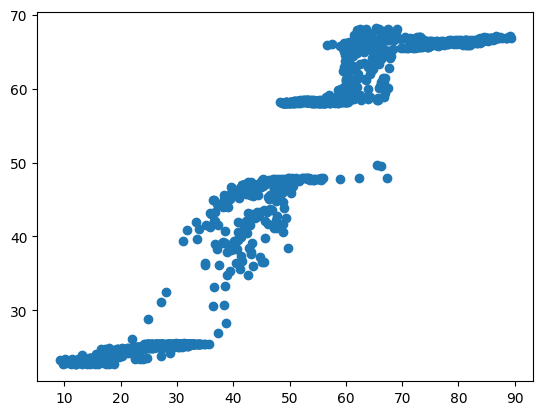

In [44]:
# Scatter plot of the resulting model prediction
axis = plt.gca()
axis.scatter(training_output, model.predict(training_input)); 
plt.show()

In [48]:
# Create neural network model
# import necessary libraries and modules
import numpy as np
from keras.models import load_model

# load the pre-trained model
pre_trained_model = load_model('pre_trained_model.h5')
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
# Use the pre-trained model to predict portfolio weights given new asset returns
asset_returns = np.array([0.001060, 0.003832, 0.000726, -0.002787])
asset_returns.shape = (1,4)
print("Predicted minimum volatility portfolio: ", pre_trained_model.predict(asset_returns))

1/1 [==============================] - 0s 62ms/step
Predicted minimum volatility portfolio:  [[0.         0.28107253 0.         0.7649856 ]]
